In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import collections
import hashlib
import numbers
from datetime import datetime
from pathlib import Path
import os

import sys
sys.path.append('../')
import long_short_term_spike_cell_v2 as spiking_cell

In [3]:
# uplading mnist data 

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

tf.logging.set_verbosity(old_v)

# Training Parameters
weight_learning_rate = 1e-5
training_steps = 5000
batch_size = 2
display_step = 5
test_len=128
grad_clip=200
# Network Parameters
num_input = 1 # MNIST data input (img shape: 28*28)
num_context_input=1
MNIST_timesteps = 28*28 # timesteps
timesteps=MNIST_timesteps+54
# 
num_unit_input_layer=80 # input layer neurons
num_context_unit=1

num_hidden = 200 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)
total_batch = int(mnist.train.num_examples / batch_size)
print("Total number of batches:", total_batch)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Total number of batches: 27500


In [7]:
def _lsnn_v2_weight_initializer(shape,dtype=None,partition_info=None,verify_shape=None, gain=0.5):
    if dtype is None:
        dtype=tf.float32
    #extract second dimension
    W_rec=tf.divide(gain*tf.random_normal(shape=[shape[0],shape[0]],mean=0,stddev=1,dtype=dtype),tf.sqrt(tf.cast(shape[0],tf.float32)))
    new_shape=[shape[0],shape[-1]-shape[0]]

    W_in = tf.divide(gain*tf.random_normal(shape=new_shape,mean=0,stddev=1,dtype=dtype),tf.sqrt(tf.cast(new_shape[-1],tf.float32)))
    #W_in=tf.random_normal(new_shape,mean=0,stddev=0.001)
    return tf.concat([W_in,W_rec],axis=1)

In [8]:
def SNN_all_states(x,context):
    with tf.variable_scope('input_context') as scope:
        context_input_layer_cell=spiking_cell.context_input_spike_cell(num_units=1,context_switch=MNIST_timesteps)
        context_initial_state = context_input_layer_cell.zero_state(batch_size, dtype=tf.float32)
        output_context, states_context = tf.nn.dynamic_rnn(context_input_layer_cell, dtype=tf.float32, inputs=context,initial_state=context_initial_state)
    with tf.variable_scope('input_layer') as scope: 
        input_layer_cell=spiking_cell.input_spike_cell(num_units=num_unit_input_layer)
        input_initial_state = input_layer_cell.zero_state(batch_size, dtype=tf.float32)
        output_l1, states_l1 = tf.nn.dynamic_rnn(input_layer_cell, dtype=tf.float32, inputs=x,initial_state=input_initial_state)
    with tf.variable_scope('hidden_layer') as scope: 
        hidden_layer_cell=spiking_cell.long_short_term_spike_cell(num_units=num_hidden,num_inputs=num_unit_input_layer+num_context_unit,state_is_tuple=True,output_is_tuple=False,
                    kernel_initializer=_lsnn_v2_weight_initializer)
        hidden_initial_state = hidden_layer_cell.zero_state(batch_size, dtype=tf.float32)
        output_hidden, states_hidden = tf.nn.dynamic_rnn(hidden_layer_cell, dtype=tf.float32, inputs=tf.concat([output_l1,output_context],-1),initial_state=hidden_initial_state)
    with tf.variable_scope('output_layer') as scope : 
        output_layer_cell=spiking_cell.output_spike_cell(num_units=num_classes,tau_m=3.0,kernel_initializer=tf.contrib.layers.xavier_initializer())
        output_voltage, voltage_states=tf.nn.dynamic_rnn(output_layer_cell,dtype=tf.float32,inputs=output_hidden)

    return output_voltage,output_hidden, tf.concat([output_l1,output_context],-1)


### test spiking and output activity

In [9]:
# Training Parameters
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # input to graph
    X=tf.placeholder('float',shape=[batch_size,timesteps,num_input])
    Context=tf.placeholder('float',shape=[batch_size,timesteps,num_context_input])
    # define out
    output_voltages,hidden_states,input_states=SNN_all_states(X,Context)
    
    trainables=tf.trainable_variables()
    variable_names=[v.name for v in tf.trainable_variables()]
    
    init=tf.global_variables_initializer()

test initializations 

['variable: ', 'hidden_layer/rnn/long_short_term_spike_cell/kernel_2D:0']
['variable: ', -1]
['shape: ', (200, 281)]
['variable: ', 'output_layer/rnn/output_spike_cell/kernel:0']
['variable: ', 0]
['shape: ', (200, 10)]


(array([3.5000e+01, 2.7800e+02, 2.0600e+03, 1.0374e+04, 2.2341e+04,
        1.6094e+04, 4.2460e+03, 6.6400e+02, 9.9000e+01, 9.0000e+00]),
 array([-0.19980033, -0.15733388, -0.11486743, -0.07240099, -0.02993454,
         0.01253191,  0.05499835,  0.0974648 ,  0.13993125,  0.1823977 ,
         0.22486414], dtype=float32),
 <a list of 10 Patch objects>)

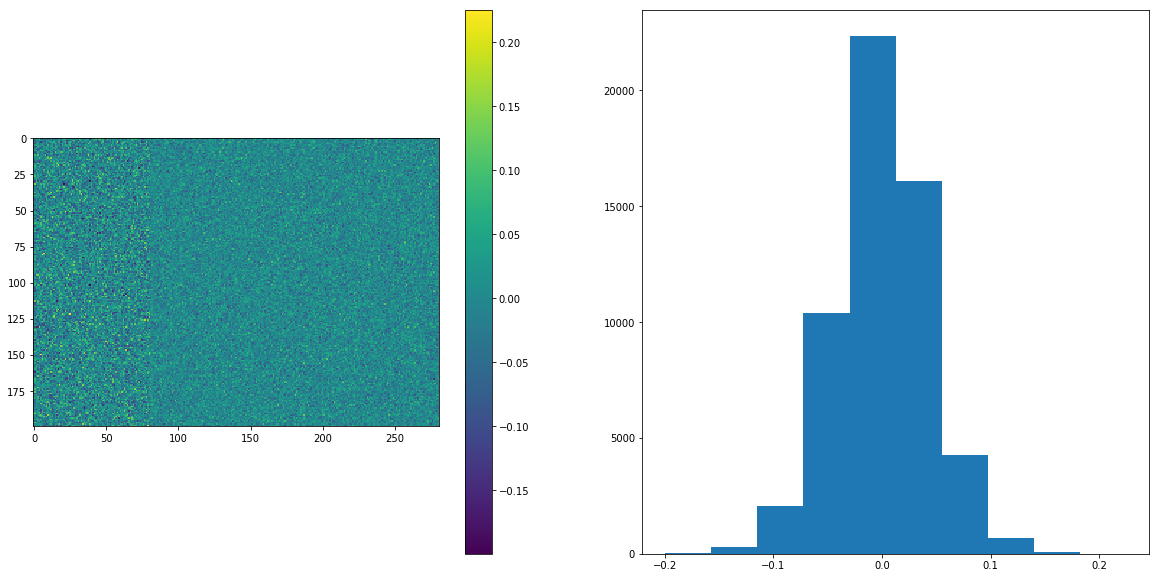

In [10]:
with tf.Session(graph=graph,) as sess : 
    sess.run(init)
    values,trainable_vars = sess.run([variable_names,trainables])
    for k, v in zip(variable_names,values):
        print(["variable: " , k])
        #print(["value: " , v])
        print(["variable: " , np.unicode_.find(k,'output')]) 
        print(["shape: " , v.shape])
        #print(v) 
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.imshow(values[0])
plt.colorbar()
plt.subplot(122)
plt.hist(values[0].flatten())



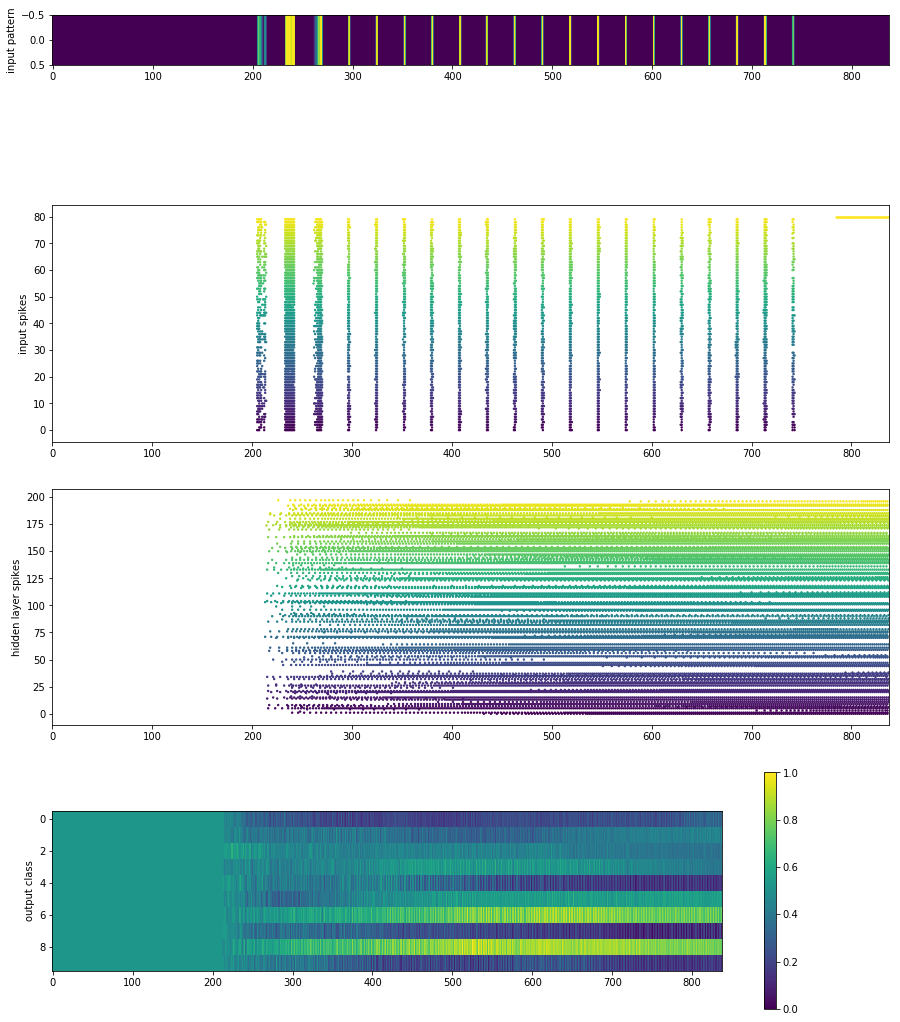

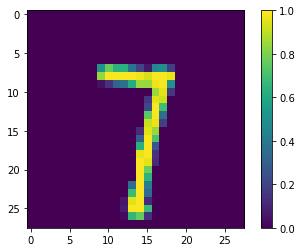

In [13]:
with tf.Session(graph=graph) as sess:
    sess.run(init)
    batch_x,batch_y=mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape((batch_size, MNIST_timesteps, num_input))
    batch_x_full=np.concatenate([batch_x,np.zeros((batch_size,timesteps-MNIST_timesteps,num_input))],axis=1)
    context_input=np.ones((batch_size,timesteps,num_context_input))
    outputs,hiddens,inputs=sess.run([output_voltages,hidden_states,input_states], feed_dict={X: batch_x_full,Context:context_input})
    
voltages=outputs[1,:,:]
hidden_spikes=hiddens[1,:,:]
input_spikes=inputs[1,:,:]
plt.figure(figsize=[15,20])

#ax1=plt.subplot(311)
#colors_map=cm.viridis(np.linspace(0,1,voltages.shape[1]))
#for t in range(num_classes):
#    ax1.plot(voltages[:,t],color=colors_map[t,:])
#    plt.xlim([0,timesteps])

ax1=plt.subplot(411)
plt.imshow(np.transpose(batch_x_full[1]))
ax1.set_aspect(50)
plt.ylabel('input pattern')
ax2=plt.subplot(412)
colors_map=cm.viridis(np.linspace(0,1,num_unit_input_layer+num_context_unit))
for t in range(timesteps):
    cross=np.argwhere(input_spikes[t,:])
    ax2.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,timesteps])
plt.ylabel('input spikes')
  
ax3=plt.subplot(413)
colors_map=cm.viridis(np.linspace(0,1,num_hidden))
for t in range(timesteps):
    cross=np.argwhere(hidden_spikes[t,:])
    ax3.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,timesteps])
plt.ylabel('hidden layer spikes')
ax1=plt.subplot(414)
ax1.imshow(np.transpose(voltages))
plt.colorbar()
ax1.set_aspect(20)
plt.ylabel('output class')

    
plt.figure()
plt.imshow(batch_x[1].reshape(28,28))
plt.colorbar()


### test gradients 

In [ ]:
def SNN_Full(x):
    with tf.variable_scope('input_layer') as scope: 
        input_layer_cell=spiking_cell_bare.input_spike_cell(num_units=num_unit_input_layer)
        input_initial_state = input_layer_cell.zero_state(batch_size, dtype=tf.float32)
        output_l1, states_l1 = tf.nn.dynamic_rnn(input_layer_cell, dtype=tf.float32, inputs=x,initial_state=input_initial_state)
    with tf.variable_scope('hidden_layer') as scope: 
        hidden_layer_cell=spiking_cell_bare.conductance_spike_Cell(num_units=num_hidden,output_is_tuple=True,tau_refract=5.0)
        hidden_initial_state = hidden_layer_cell.zero_state(batch_size, dtype=tf.float32)
        output_hidden, states_hidden = tf.nn.dynamic_rnn(hidden_layer_cell, dtype=tf.float32, inputs=output_l1,initial_state=hidden_initial_state)
    with tf.variable_scope('output_layer') as scope : 
        output_layer_cell=spiking_cell_bare.output_spike_cell(num_units=num_classes)
        output_voltage, voltage_states=tf.nn.dynamic_rnn(output_layer_cell,dtype=tf.float32,inputs=output_hidden.spike)

    return output_voltage, output_hidden

In [ ]:
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # define weights and inputs to the network
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    # define a function for extraction of variable names
    SNN_output,SNN_hidden_states=SNN_Full(X)
    trainables=tf.trainable_variables()
    variable_names=[v.name for v in tf.trainable_variables()]
    # 
    find_joing_index = lambda x, name_1,name_2 : [a and b for a,b in zip([np.unicode_.find(k.name, name_1)>-1 for k in x] ,[np.unicode_.find(k.name, name_2)>-1 for k in x])].index(True)
    # find trainable parameters for keRNL 
    with tf.name_scope('SNN_Trainables') as scope:
        SNN_hidden_kernel_index= find_joing_index(trainables,'hidden_layer','kernel')
        SNN_hidden_bias_index= find_joing_index(trainables,'hidden_layer','bias')
        SNN_output_kernel_index= find_joing_index(trainables,'output_layer','kernel')
        SNN_output_bias_index= find_joing_index(trainables,'output_layer','bias')
    # 
        SSN_weight_training_indices=np.asarray([SNN_hidden_kernel_index,SNN_hidden_bias_index,SNN_output_kernel_index,SNN_output_bias_index],dtype=np.int)
        SNN_weight_trainables= [trainables[k] for k in SSN_weight_training_indices]
    #
    #define loss functions  
    ##################
    # SNN train ####
    ##################
    with tf.name_scope("SNN_train") as scope:
        # outputs 
        SNN_loss_output_prediction=tf.losses.softmax_cross_entropy(onehot_labels=Y,logits=SNN_output[:,-1,:])
        SNN_prediction = tf.nn.softmax(SNN_output[:,-1,:])
        SNN_correct_pred = tf.equal(tf.argmax(SNN_prediction, 1), tf.argmax(Y, 1))
        SNN_accuracy = tf.reduce_mean(tf.cast(SNN_correct_pred, tf.float32))
       # define optimizer 
        SNN_weight_optimizer = tf.train.AdamOptimizer(learning_rate=weight_learning_rate)
        
       
        with tf.name_scope('SNN_train_weights') as scope: 
            SNN_grad_cost_trainables=tf.gradients(SNN_loss_output_prediction,SNN_weight_trainables)
            
            # crop the gradients  
            #SNN_weight_grads_and_vars=list(zip(SNN_grad_cost_trainables,SNN_weight_trainables))
            #SNN_cropped_weight_grads_and_vars=[(tf.clip_by_norm(grad, grad_clip),var) if  np.unicode_.find(var.name,'output')==-1 else (grad,var) for grad,var in SNN_weight_grads_and_vars]
            # apply gradients 
            #SNN_weight_train_op = SNN_weight_optimizer.apply_gradients(SNN_cropped_weight_grads_and_vars)
        with tf.name_scope('SNN_check_gradients') as scope:
            spike_to_voltage_gradient=tf.gradients(ys=SNN_hidden_states.v_mem,xs=SNN_hidden_states.spike)
        init = tf.global_variables_initializer()
    

In [ ]:
with tf.Session(graph=graph,) as sess : 
    sess.run(init)
    values,trainable_vars = sess.run([variable_names,trainables])
    for k, v in zip(variable_names,values):
        print(["variable: " , k])
        #print(["value: " , v])
        print(["variable: " , np.unicode_.find(k,'output')]) 
        print(["shape: " , v.shape])
        #print(v) 
spike_to_voltage_gradient

In [ ]:
with tf.Session(graph=graph) as sess:
    sess.run(init)
    batch_x,batch_y=mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape((batch_size, timesteps, num_input))
    outputs,hidden_states=sess.run([SNN_output,SNN_hidden_states],feed_dict={X:batch_x, Y:batch_y})
    spike_2_v_mem_grad=sess.run(SNN_grad_cost_trainables,feed_dict={X:batch_x, Y:batch_y})

In [ ]:
v_mems=hidden_states.v_mem
plt.figure(figsize=[15,10])
plt.imshow(np.transpose(v_mems[9,:,:]))
plt.colorbar()

looks like negative values dominates the activity of the cells, question is should I change something about the negative amplitudes

In [ ]:
a=spike_2_v_mem_grad[0]
plt.figure(figsize=[10,15])
plt.imshow(a)
plt.colorbar()


In [ ]:
a=np.arange(1,50)
a

In [ ]:
a[-1-20:
 ]